# Setup 

The code is based on Agerons code at github https://github.com/ageron/handson-ml3

In [6]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project" 
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

Variables for path for download, path for saving file and function for fetching the data 

In [7]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Call the function 

In [ ]:
fetch_housing_data()

Creates a "load to pandas DataFrame" function and call it

In [9]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()

Inspect the data:

In [10]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [11]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Test and train sets

In [12]:
from sklearn.model_selection import train_test_split
#Splitting the dataset into two datasets, features and labels
housing_features = housing.drop("median_house_value", axis=1)
housing_labels = housing["median_house_value"]

#Create training and test sets (random)
housing_train_features, housing_test_features, housing_train_labels, housing_test_labels = train_test_split(housing_features, housing_labels, test_size=0.2, random_state=42)

# Custom features

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
    

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

Pipelines for data transformation

In [14]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import make_column_selector, ColumnTransformer

#Pipline to handle categories, it fills in (impute) null values with the most frequent value and then encodes it with OneHot encoding
cat_pipeline = Pipeline([
    ("impute",SimpleImputer(strategy="most_frequent")),
    ("encoder",OneHotEncoder(handle_unknown="ignore"))
])
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

#Pipline to handle categories, it fills in (impute) null values with the most frequent value and then encodes it with OneHot encoding
cat_pipeline = Pipeline([
    ("impute",SimpleImputer(strategy="most_frequent")),
    ("encoder",OneHotEncoder(handle_unknown="ignore"))
])


preprocessing_pipeline = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

Pipelines for training the models:

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#Creates a linear regression pipeline with preprocessing
lin_reg_pipeline = Pipeline([
    ("preprocessing",preprocessing_pipeline), 
    ("linear_regression", LinearRegression())
])

#Creates a decision tree pipeline with preprocessing
decision_tree_reg_pipeline = Pipeline([
    ("preprocessing",preprocessing_pipeline),
    ("decision_tree", DecisionTreeRegressor())
])

random_forest_reg_pipeline = Pipeline([
    ("preprocessing", preprocessing_pipeline),
    ("random_forest_regression", RandomForestRegressor(random_state=42, n_jobs=-1)) #Set n_jobs=-1 to use all cpu cores
])

#Creates a SVM(regression) pipeline

svr_pipeline = Pipeline([
    ("preprocessing", preprocessing_pipeline),
    ("SVR_regression", SVR(C=1, epsilon=0.2, kernel="linear"))
])

Linear regression:

In [16]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
linear_reg_scores = -cross_val_score(lin_reg_pipeline, housing_train_features, housing_train_labels, scoring="neg_root_mean_squared_error", cv=10)
linear_reg_scores_mean = linear_reg_scores.mean()
pd.Series(linear_reg_scores).describe()



count       10.000000
mean     68315.082767
std       1909.908213
min      65496.379955
25%      66892.076799
50%      68202.325778
75%      69628.314104
max      71563.331339
dtype: float64

Decision tree regression:

In [17]:
decision_tree_reg_scores = -cross_val_score(decision_tree_reg_pipeline, housing_train_features, housing_train_labels, scoring="neg_root_mean_squared_error", cv=10)
decision_tree_reg_scores_mean = decision_tree_reg_scores.mean()
pd.Series(decision_tree_reg_scores).describe()


count       10.000000
mean     66554.065230
std       2255.545886
min      62336.037137
25%      65100.164972
50%      67159.786183
75%      67851.564421
max      69864.769253
dtype: float64

Random forest regression:

In [18]:
random_forest_scores = -cross_val_score(random_forest_reg_pipeline, housing_train_features, housing_train_labels, scoring="neg_root_mean_squared_error", cv=10)
random_forest_scores_mean = random_forest_scores.mean()
pd.Series(random_forest_scores).describe()

count       10.000000
mean     46976.553291
std       2058.981796
min      44106.745679
25%      45121.642231
50%      47028.117967
75%      48920.501984
max      49570.985996
dtype: float64

Support vector machine regression:

In [19]:
svr_scores = -cross_val_score(svr_pipeline, housing_train_features, housing_train_labels, scoring="neg_root_mean_squared_error", cv=10)
svr_scores_mean = svr_scores.mean()
pd.Series(svr_scores).describe()


count        10.000000
mean     111880.860473
std        2144.220532
min      107910.592603
25%      110616.852897
50%      112558.294435
75%      112982.279568
max      114854.321596
dtype: float64

Tune hyperparameters with GridSearchCV for SVR 

In [30]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'svr__kernel': ['linear'], 'svr__C': [10., 30., 100., 300., 1000.,
                                               3000., 10000., 30000.0]},
        {'svr__kernel': ['rbf'], 'svr__C': [1.0, 3.0, 10., 30., 100., 300.,
                                            1000.0],
         'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svr_pipeline = Pipeline([("preprocessing", preprocessing_pipeline), ("svr", SVR())])
grid_search = GridSearchCV(svr_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
##Grid search run on 5000 rows of train data.
grid_search.fit(housing_train_features.iloc[:5000], housing_train_labels.iloc[:5000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002A6A40EFBF0>)])),
                                       ('svr', SVR())]),
             param_grid=[{'svr__C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                     10000.0, 30000.0],
                          'svr__kernel': ['linear']},
                         {'svr__C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0,
                                     1000.0],
                          'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

In [31]:
svr_grid_search_rmse = -grid_search.best_score_
svr_grid_search_rmse

np.float64(71268.26079818109)

In [32]:
grid_search.best_params_

{'svr__C': 3000.0, 'svr__kernel': 'linear'}

Creates a dict from all scores

In [33]:
scoring_dict = {
    "Linear regression": linear_reg_scores_mean,
    "Decision tree regression": decision_tree_reg_scores_mean,
    "Random forest regression": random_forest_scores_mean,
    "SVR default parameters": svr_scores_mean,
    "SVR tuned parameters" : svr_grid_search_rmse
}

Plot the data

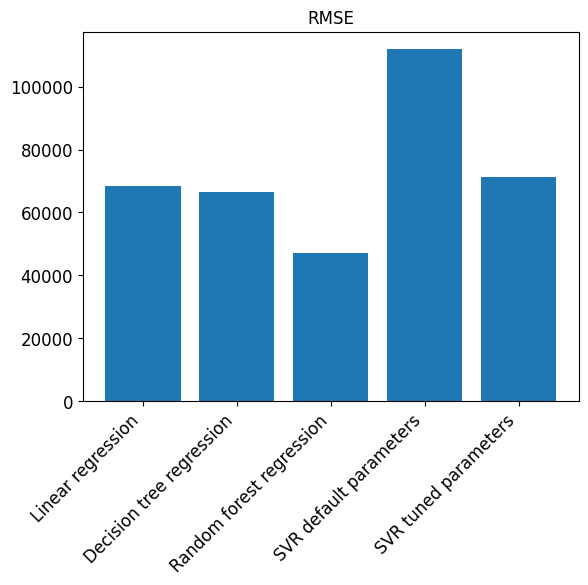

In [34]:
import matplotlib.pyplot as plt


keys = list(scoring_dict.keys())
values = list(scoring_dict.values())


plt.bar(keys, values)

# Adjust labels and title
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.title("RMSE")

# Show plot
plt.show()
